## Use customized KDE kernel to imitate LLaMA
- [x] Implement 2D fit 
- [x] Implement uncertainty of fit

In [1]:
import sys
import os
from pathlib import Path

import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
sys.path.append("../models")
processed_series_path = Path(parent_dir) / 'processed_series'
# processed_series_path = Path(parent_dir) / '..' / 'llmICL' / 'processed_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output
from ipywidgets import interact, IntSlider, FloatSlider

print(sys.path)
from ICL import MultiResolutionPDF
from models.baseline_models import *



def average_PDF_list(PDF_list, avg_interval = 6):
    """
    rolling average over a list of hierarchy PDFs
    """
    PDF_list_averaged = []
    common_bin_center_arr = PDF_list[0].bin_center_arr
    common_bin_width_arr = PDF_list[0].bin_width_arr
    for i in range(len(PDF_list)-avg_interval):
        avg_bin_height_arr = np.average([PDF_list[i+x].bin_height_arr for x in range(avg_interval)], axis = 0)
        avg_PDF = MultiResolutionPDF()
        avg_PDF.add_bin(common_bin_center_arr, common_bin_width_arr, avg_bin_height_arr)
        PDF_list_averaged += [avg_PDF]
    return PDF_list_averaged
        
def gaussian_manifold_generator(PDF_list, sigma_list, mean_list):
    """
        PDF_list: example PDF
    """
    assert len(sigma_list) == len(mean_list), "Sigma list and mean list must be of the same length"
    PDF_manifold_list = copy.deepcopy(PDF_list[:len(sigma_list)])
    for i, (sigma, mean) in enumerate(zip(sigma_list, mean_list)):
        def cdf(x):
            return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))
        PDF_manifold_list[i].discretize(cdf, mode = 'cdf')
        
    return PDF_manifold_list
    
def temperature_manifold_generator(true_PDF, temperature_list):
    PDF_manifold_list = [copy.deepcopy(true_PDF) for _ in temperature_list]
    for i, alpha in enumerate(temperature_list):
        # PDF_manifold_list[i].bin_height_arr += 0.01
        PDF_manifold_list[i].rescale_temperature(alpha)
    return PDF_manifold_list

def geodesic_from_true_stat(PDF_list, true_stat, geodesic_steps = 20):
    """
        PDF_list: example PDF
        true_stat: statistics of true distribution
    """

    PDF_geodesic_list = copy.deepcopy(PDF_list[:geodesic_steps])
    PDF_ignorance = copy.deepcopy(PDF_list[0])
    def cdf(x):
        return np.clip(x / 10, 0, 1)
    PDF_ignorance.discretize(cdf, mode = "cdf")

    PDF_true = copy.deepcopy(PDF_list[-1])
    
    if true_stat['true_PDF'] is not None:
        PDF_true = true_stat['true_PDF']        
    else:
        if true_stat['dist type'] == 'gaussian':
            def cdf(x):
                return 0.5 * (1 + erf((x - true_stat['rescaled_true_mean']) / (true_stat['rescaled_true_sigma'] * np.sqrt(2))))
        elif true_stat['dist type'] == 'uniform':
            low = true_stat['rescaled_true_mean'] - true_stat['rescaled_true_sigma']
            high = true_stat['rescaled_true_mean'] + true_stat['rescaled_true_sigma']
            def cdf(x):
                return np.where((x >= low) & (x <= high), (x - low) / (high - low), np.where(x < low, 0, 1))
        PDF_true.discretize(cdf, mode = "cdf")


    PDF_ignorance_sqrt = np.sqrt(PDF_ignorance.bin_height_arr)
    PDF_true_sqrt = np.sqrt(PDF_true.bin_height_arr)
    dG = np.arccos(1-PDF_true.Hel_dist(PDF_ignorance)**2/2)
    denom = np.sin(dG)
    for i in range(geodesic_steps):
        a = i/geodesic_steps
        u_coef = np.sin((1-a)*dG)/denom
        v_coef = np.sin(a*dG)/denom
        PDF_geodesic_list[i].bin_height_arr = np.square(u_coef * PDF_ignorance_sqrt + v_coef * PDF_true_sqrt)
    return PDF_geodesic_list        
    
all_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
for index, file in enumerate(all_files):
    series_dict = pickle.load(file.open('rb'))
    llama_size = series_dict['llama_size']
    random_seed = series_dict['random_seed']
    kernel = series_dict.get('kernel', '')
    # print(f"[{index}]: {file.name}, {llama_size}, {random_seed}, {kernel}")    

['/home/admin-quad/Toni/LLMICL_inPCA/inPCA', '/home/admin-quad/anaconda3/envs/LLM/lib/python311.zip', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/lib-dynload', '', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/site-packages', '/home/admin-quad/LLM/llama', '/home/admin-quad/Toni/LLMICL_inPCA', '../models']


In [2]:
import re
def find_file(files, llama_size=None, sigma=None, kernel=None, random_seed=None, bw_function_name=None, dist_type=None, l=None):
    for file in files:
        matches = True
        
        # Extract sigma from filename
        sigma_match = re.search(r'sigma_([\d.]+)', file.name)
        l_match = re.search(r'l_([\d.]+)', file.name)
        file_sigma = float(sigma_match.group(1)) if sigma_match else None
        file_l = float(l_match.group(1)) if l_match else None
        
        series_dict = pickle.load(file.open('rb'))
        
        # Check llama_size
        if llama_size is not None and series_dict.get('llama_size') != llama_size:
            matches = False
        
        # Check sigma
        if sigma is not None and file_sigma != sigma:
            matches = False
        
        # Check kernel
        if kernel is not None and series_dict.get('kernel', '') != kernel:
            matches = False
        
        # Check random_seed
        if random_seed is not None and series_dict.get('random_seed') != random_seed:
            matches = False
            
        if l is not None and file_l != l:
            matches = False
            
        # check distribution type
        # Check distribution type
        if dist_type is not None:
            if dist_type not in file.name:
                matches = False
        
        # Check bw_function_name
        if bw_function_name is not None:
            if 'bw_function_name' not in series_dict or series_dict['bw_function_name'] != bw_function_name:
                matches = False
        if bw_function_name is None:
            if 'bw_function_name' in series_dict:
                matches = False
        
        if matches:
            return file
    return None

In [3]:
alpha = 1
avg_interval = 5
# avg_interval = 1
geodesic_steps = 40
# geodesic_steps = 5
gaussian_manifold = True
temperature_manifold = False
### Keep only 1 true statistic
PDF_slice = slice(0,150)

use_true_PDF = 1

In [4]:
if gaussian_manifold and temperature_manifold:
    raise ValueError("Cannot plot both gaussian and temperature manifolds simultaneously")

PDF_list_multi_traj = []
true_statistics = []
traj_names = []

name = f"../figures/nD_kernel_fit_experiment"

default_dist = 'gaussian'
color_list = ["C0", "C1", "C2", "C3", "C4", "C5", "C6"]


# Select files based on their attributes, allowing some to be unspecified
# default_dist = 'gaussian
# name = f"../paper_figures/fitted_kernel_13b_gaussian_0.1"
# selected_files = [
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian',bw_function_name = None),
#     # find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian',bw_function_name = 'customized_3'),
#     # find_file(all_files, llama_size='KDE', sigma=0.1, kernel='epanechnikov',bw_function_name = 'customized_3'),
#     # find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian',bw_function_name = 'constant'),
#     # find_file(all_files, llama_size='histogram', sigma=0.1, kernel=None),
# ]

# default_dist = 'gaussian'
# color_list = ["C0", "C3","brown"]
# marker_list = ["o", "s","^"]
# name = f"../paper_figures/fitted_kernel_13b_gaussian_0.3"
# target_idx = 0
# selected_files = [
#     find_file(all_files, llama_size='13b', sigma=0.3, kernel=None),
#     # find_file(all_files, llama_size='70b', sigma=0.3, kernel=None),
#     find_file(all_files, llama_size='KDE', sigma=0.3, kernel='gaussian',bw_function_name = None),
# ]

# default_dist = 'gaussian'
# color_list = ["C0", "C3","brown"]
# marker_list = ["o", "s","^"]
# name = f"../paper_figures/fitted_kernel_13b_gaussian_0.5"
# target_idx = 0
# selected_files = [
#     find_file(all_files, llama_size='13b', sigma=0.5, kernel=None),
#     # find_file(all_files, llama_size='70b', sigma=0.5, kernel=None),
#     find_file(all_files, llama_size='KDE', sigma=0.5, kernel='gaussian',bw_function_name = None),
# ]

# real_silverman = False
# color_list = ["C0", "C3","brown"]
# marker_list = ["o", "s","^"]
# default_dist = 'gaussian'
# target_idx = 0
# name = f"../paper_figures/fitted_kernel_13b_gaussian_0.1"
# selected_files = [
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian',bw_function_name = None),
# ]

# PDF_slice = slice(0,100)
# color_list = ["C1", "C0", "C2", "C3", "C4"]
# marker_list = [ "s","o","^"]
# name = f"../paper_figures/gaussian_0.1_7_13_70_KDE_hist"
# selected_files = [
    
#     find_file(all_files, llama_size='7b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='70b', sigma=0.1, kernel=None),
    # find_file(all_files, llama_size='KDE', sigma=0.3, kernel='gaussian'),
    # find_file(all_files, llama_size='histogram', sigma=0.3, kernel=None),
# ]

# color_list = ["C0", "C3","brown"]
# marker_list = ["o", "s","^"]
# default_dist = 'uniform'
# target_idx = 0
# name = f"../paper_figures/fitted_kernel_13_uniform_0.1"
# selected_files = [
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian',bw_function_name = None, dist_type = 'uniform'),
# ]

# color_list = ["C0", "C3","brown"]
# marker_list = ["o", "s","^"]
# default_dist = 'uniform'
# target_idx = 0
# name = f"../paper_figures/fitted_kernel_13_uniform_0.3"
# selected_files = [
#     find_file(all_files, llama_size='13b', sigma=0.3, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='KDE', sigma=0.3, kernel='gaussian',bw_function_name = None, dist_type = 'uniform'),
# ]

# color_list = ["C0", "C3","brown"]
# marker_list = ["o", "s","^"]
# default_dist = 'uniform'
# target_idx = 0
# name = f"../paper_figures/fitted_kernel_13_uniform_0.5"
# selected_files = [
#     find_file(all_files, llama_size='13b', sigma=0.5, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='KDE', sigma=0.5, kernel='gaussian',bw_function_name = None, dist_type = 'uniform'),
# ]

"""

color_list = ["C0", "C3","brown"]
marker_list = ["o", "s","^"]
name = f"../paper_figures/fitted_kernel_70b_random_0.1_seed_5"
target_idx = 0
selected_files = [
    find_file(all_files, llama_size='70b', l=0.1, random_seed=5, kernel=None),
    find_file(all_files, llama_size='KDE', l=0.1, random_seed=5, kernel=None,bw_function_name = None),
]
"""

"""
color_list = ["C0", "C3","brown"]
marker_list = ["o", "s","^"]
name = f"../paper_figures/fitted_kernel_13b_random_0.1_seed_7"
target_idx = 0
selected_files = [
    find_file(all_files, llama_size='13b', l=0.1, random_seed=7, kernel=None),
    find_file(all_files, llama_size='KDE', l=0.1, random_seed=7, kernel=None,bw_function_name = None),
]
"""
"""
name = f"../paper_figures/fitted_kernel_13b_random_0.1_seed_13"
target_idx = 0
selected_files = [
    # find_file(all_files, llama_size='70b', l=0.1, random_seed=13, kernel=None),
    find_file(all_files, llama_size='13b', l=0.1, random_seed=13, kernel=None),   
    find_file(all_files, llama_size='KDE', l=0.1, random_seed=13, kernel='gaussian',bw_function_name = None),
]

"""

# """
# # available seeds: 0,1,3,5,7,9,11,13,15,17

# name = f"../paper_figures/fitted_kernel_13b_random_0.1_seed_17"
# target_idx = 0
# selected_files = [
#     # find_file(all_files, llama_size='70b', l=0.1, random_seed=17, kernel=None),
#     find_file(all_files, llama_size='13b', l=0.1, random_seed=17, kernel=None),
#     find_file(all_files, llama_size='KDE', l=0.1, random_seed=17, kernel='gaussian',bw_function_name = None),
# ]

# ## available seeds: 0,1,3,5,7,9,11,13,15,17
# name = f"../paper_figures/fitted_kernel_13b_random_0.1_seed_15"
# target_idx = 0
# selected_files = [
#     # find_file(all_files, llama_size='70b', l=0.1, random_seed=15, kernel=None),
#     find_file(all_files, llama_size='13b', l=0.1, random_seed=15, kernel=None),
#     find_file(all_files, llama_size='KDE', l=0.1, random_seed=15, kernel='gaussian',bw_function_name = None),
# ]

## available seeds: 0,1,3,5,7,9,11,13,15,17
name = f"../paper_figures/0_fig_fitted_kernel_13b_random_0.1_seed_15"
target_idx = 0
selected_files = [
    # find_file(all_files, llama_size='70b', l=0.1, random_seed=15, kernel=None),
    find_file(all_files, llama_size='13b', l=0.1, random_seed=15, kernel=None),
    find_file(all_files, llama_size='KDE', l=0.1, random_seed=15, kernel='gaussian',bw_function_name = None),
]

# name = f"../paper_figures/fitted_kernel_13b_random_0.5_seed_15"
# marker_list = ["o", "s","^"]
# target_idx = 0
# selected_files = [
#     # find_file(all_files, llama_size='70b', l=0.5, random_seed=15, kernel=None),
#     find_file(all_files, llama_size='13b', l=0.5, random_seed=15, kernel=None),
#     find_file(all_files, llama_size='KDE', l=0.5, random_seed=15, kernel='gaussian',bw_function_name = None),
# ]

# name = f"../paper_figures/fitted_kernel_13b_random_0.02_seed_3"
# marker_list = ["o", "s","^"]
# target_idx = 0
# selected_files = [
#     find_file(all_files, llama_size='13b', l=0.02, random_seed=3, kernel=None),
#     find_file(all_files, llama_size='KDE', l=0.02, random_seed=3, kernel='gaussian',bw_function_name = None),
# ]

# name = f"../paper_figures/fitted_kernel_13b_random_0.02_seed_15"
# marker_list = ["o", "s","^"]
# target_idx = 0
# selected_files = [
#     find_file(all_files, llama_size='13b', l=0.02, random_seed=15, kernel=None),
#     find_file(all_files, llama_size='KDE', l=0.02, random_seed=15, kernel='gaussian',bw_function_name = None),
# ]

# name = f"../paper_figures/fitted_kernel_13b_random_0.02_seed_7"
# marker_list = ["o", "s","^"]
# target_idx = 0
# selected_files = [
#     find_file(all_files, llama_size='13b', l=0.02, random_seed=7, kernel=None),
#     find_file(all_files, llama_size='KDE', l=0.02, random_seed=7, kernel='gaussian',bw_function_name = None),
# ]

# name = f"../paper_figures/fitted_kernel_13b_random_0.1_seed_7"
# marker_list = ["o", "s","^"]
# target_idx = 0
# selected_files = [
#     find_file(all_files, llama_size='13b', l=0.1, random_seed=7, kernel=None),
#     find_file(all_files, llama_size='KDE', l=0.1, random_seed=7, kernel='gaussian',bw_function_name = None),
# ]



# Remove any None values in case a file wasn't found
selected_files = [f for f in selected_files if f is not None]
print(selected_files)



for file in selected_files:
    processed_dict = pickle.load(file.open('rb'))
    PDF_list_multi_traj.append(processed_dict['PDF_list'])
    llama_size = processed_dict['llama_size']
    kernel = processed_dict.get('kernel', None)
    bw_function_name = processed_dict.get('bw_function_name', None)
    print(llama_size, len(processed_dict['PDF_list']))
    if kernel is not None:
        traj_name = f"{llama_size}_{kernel}"
        if bw_function_name is not None:
            traj_name += f"_{bw_function_name}"
        traj_names += [traj_name]
    else:
        traj_names += [f"{llama_size}"]
    true_stat = {
        'dist type':  processed_dict.get('dist type', default_dist),
        'rescaled_true_mean': processed_dict.get('rescaled_true_mean_arr', [None])[-1],
        'rescaled_true_sigma': processed_dict.get('rescaled_true_sigma_arr',[None])[-1],
        'true_PDF': processed_dict.get('true_PDF',None)
    }
    true_statistics.append(true_stat)


if use_true_PDF:
    true_PDF = true_statistics[0]['true_PDF']
    true_statistics = true_statistics[0:1]
else:
    # remove repeated true statistics
    true_statistics = [dict(t) for t in {tuple(d.items()) for d in true_statistics}]


### tune temperature and sort by bin center
for PDF_list in PDF_list_multi_traj:
    for PDF in PDF_list:
        PDF.sort_by_center()
        if alpha != 1:
            PDF.rescale_temperature(alpha)
            
### average over steps
for i in range(len(PDF_list_multi_traj)):
    PDF_list_multi_traj[i] = average_PDF_list(PDF_list_multi_traj[i], avg_interval = avg_interval)


[PosixPath('/home/admin-quad/Toni/LLMICL_inPCA/processed_series/uncorrelated_random_PDF_l_0.1_13b_16.pkl'), PosixPath('/home/admin-quad/Toni/LLMICL_inPCA/processed_series/uncorrelated_random_PDF_l_0.1_KDE_37.pkl')]
13b 900
KDE 900


In [6]:
target_idx = 0

In [7]:


name_convert_dict = {'7b':'LLaMA-2 7b', '70b_NA':'LLaMA-2 70b', '13b_NA':'LLaMA-2 13b', '13b':'LLaMA-2 13b', '70b':'LLaMA-2 70b', 'KDE_gaussian': 'gaussian KDE', 'histogram_NA': "histogram", 'KDE_exponential': 'exponential KDE', 'KDE_tophat': 'tophat KDE'}
traj_names = [name_convert_dict.get(name, name) for name in traj_names]
print(traj_names)


['LLaMA-2 13b', 'gaussian KDE']


In [8]:
### check that the rescaled full series is the one used by LLaMA

processed_dict = pickle.load(selected_files[1].open('rb'))
rescaled_full_series = processed_dict['rescaled_full_series']
rescaled_full_series[:5]

array([6.15, 6.45, 4.65, 6.85, 7.55])

### Visualize multi-digit trajectory


In [9]:
len(PDF_list_multi_traj[0])
# PDF_list_multi_traj[0]

895

In [10]:
import matplotlib.pyplot as plt

@interact(step=IntSlider(min=0, max=len(PDF_list_multi_traj[0])-1, step=1, value=10))
def plot_PDFs(step):
    fig, axes = plt.subplots(len(PDF_list_multi_traj), 1, figsize=(4, 3))
    if len(PDF_list_multi_traj) == 1:
        axes = [axes]
    
    for i, (name, PDF_traj) in enumerate(zip(traj_names, PDF_list_multi_traj)):
        axes[i].clear()
        PDF_traj[step].plot(ax=axes[i], statistic = False)
        axes[i].set_title(f"{name}")
    
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=10, description='step', max=894), Output()), _dom_classes=('widget-inter…

### Figure 0

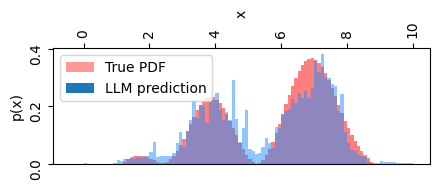

In [45]:
### Calculate geodesic 
step = -1
PDF_geodesic_list_multi_traj = []
example_PDF_list = PDF_list_multi_traj[0]

LLaMA_PDF = PDF_list_multi_traj[0][step]
true_PDF = geodesic_from_true_stat(example_PDF_list,
                            true_statistics[-1],
                            geodesic_steps=geodesic_steps)[-1]


# Create a figure with two subplots
fig, ax = plt.subplots(1, 1, figsize=(4.5, 2))

true_PDF.plot(ax=ax, statistic=False, uniform_color='red', alpha=0.5)
LLaMA_PDF.plot(ax=ax, statistic=False, alpha=0.5)

# Create ghost labels
ax.bar(0, 0, color='red', alpha=0.4, label='True PDF')
ax.bar(0, 0, color='C0', alpha=1, label='LLM prediction')


ax.set_xlabel('x', rotation=90)
ax.set_ylabel('p(x)', rotation=90)
ax.legend()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.yticks(rotation=90)

save_path = f"{name}_truth_and_prediction.png"
plt.savefig(save_path, bbox_inches='tight')
plt.tight_layout()

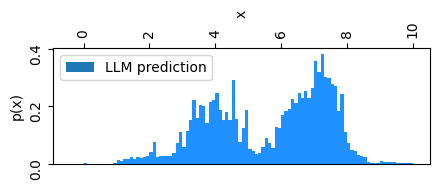

In [41]:

# Create a figure with two subplots
fig, ax = plt.subplots(1, 1, figsize=(4.5, 2))

LLaMA_PDF.plot(ax=ax, statistic=False, alpha=1)

# Create ghost labels
# ax.bar(0, 0, color='red', alpha=0.4, label='True PDF')
ax.bar(0, 0, color='C0', alpha=1, label='LLM prediction')


ax.set_xlabel('x', rotation=90)
ax.set_ylabel('p(x)', rotation=90)
ax.legend()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.yticks(rotation=90)

save_path = f"{name}_prediction.png"
plt.savefig(save_path, bbox_inches='tight')
plt.tight_layout()

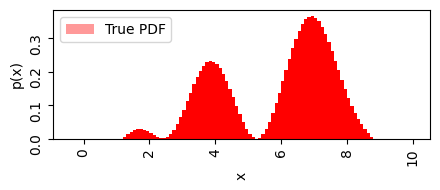

In [44]:

# Create a figure with two subplots
fig, ax = plt.subplots(1, 1, figsize=(4.5, 2))

true_PDF.plot(ax=ax, statistic=False, uniform_color='red', alpha=1)

# Create ghost labels
ax.bar(0, 0, color='red', alpha=0.4, label='True PDF')
# ax.bar(0, 0, color='C0', alpha=1, label='LLM prediction')


ax.set_xlabel('x', rotation=90)
ax.set_ylabel('p(x)', rotation=90)
ax.legend()
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.yticks(rotation=90)

save_path = f"{name}_true.png"
plt.savefig(save_path, bbox_inches='tight')
plt.tight_layout()

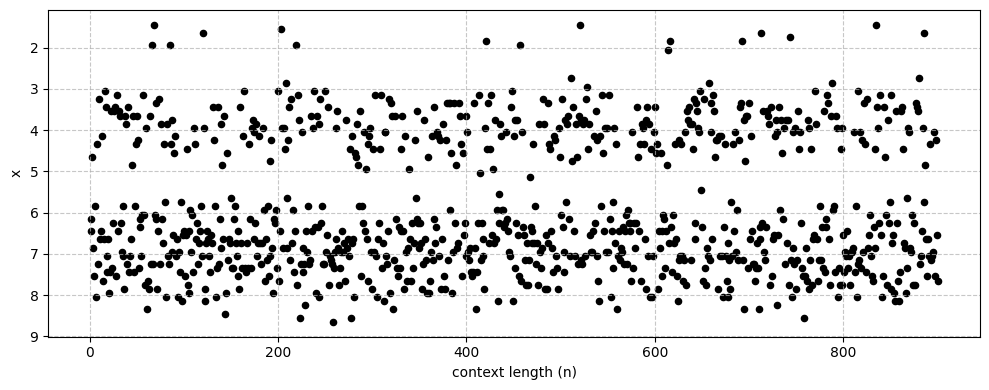

In [49]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 4))
plt.scatter(range(1, len(rescaled_full_series) + 1), rescaled_full_series, color='black', s=20)

# Set labels and title
plt.xlabel('context length (n)')
plt.ylabel('x')
# plt.title('Rescaled Full Series')
# Invert x-axis
plt.gca().invert_yaxis()

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and save
plt.tight_layout()
save_path = f"{name}_rescaled_full_series.png"
plt.savefig(save_path, bbox_inches='tight')

plt.show()

### Fit KDE

In [10]:
import math
# def poly_exp_dist(n):
#     normalization = 2 * math.gamma(1+1/n)
#     def curry_func(x):
#         return np.exp(-np.power(np.abs(x), n)) / normalization 
#     return curry_func

def poly_exp_dist(n):
    """
    Constant variance
    """
    normalization = 2 * math.gamma(1+1/n)
    var = math.gamma(3/n + 1) / math.gamma(1+1/n) / 3
    std = np.sqrt(var)
    def curry_func(x):
        return np.exp(-np.power(np.abs(x * std), n)) * std / normalization 
    return curry_func

@interact(n=FloatSlider(min=0.3, max=2, step=0.01, value=0.3, description='n:'))
def plot_poly_exp_dist(n):
    kernel = poly_exp_dist(n)
    x_values = np.linspace(-5, 5, 400)
    p_values = kernel(x_values)
    # Calculate the variance of the distribution
    variance = np.sum(x_values**2 * p_values)
    # Calculate the total probability (area under the curve)
    total_probability = np.trapz(p_values, x_values)
    print(f"Total probability: {total_probability:.4f}")
    print(f"Variance of the distribution: {variance:.4f}")
    plt.figure(figsize=(10, 4))
    plt.plot(x_values, p_values)
    plt.title(f'Normalized Poly-exponential Distribution (n = {n:.2f})')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    plt.ylim(0, 2)
    plt.grid(True)
    plt.show()

interactive(children=(FloatSlider(value=0.3, description='n:', max=2.0, min=0.3, step=0.01), Output()), _dom_c…

### Plot kernel shape for paper

/tmp/ipykernel_292100/2681951064.py:8: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  normalization = 2 * np.math.gamma(1+1/n)
/tmp/ipykernel_292100/2681951064.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  var = np.math.gamma(3/n + 1) / np.math.gamma(1+1/n) / 3


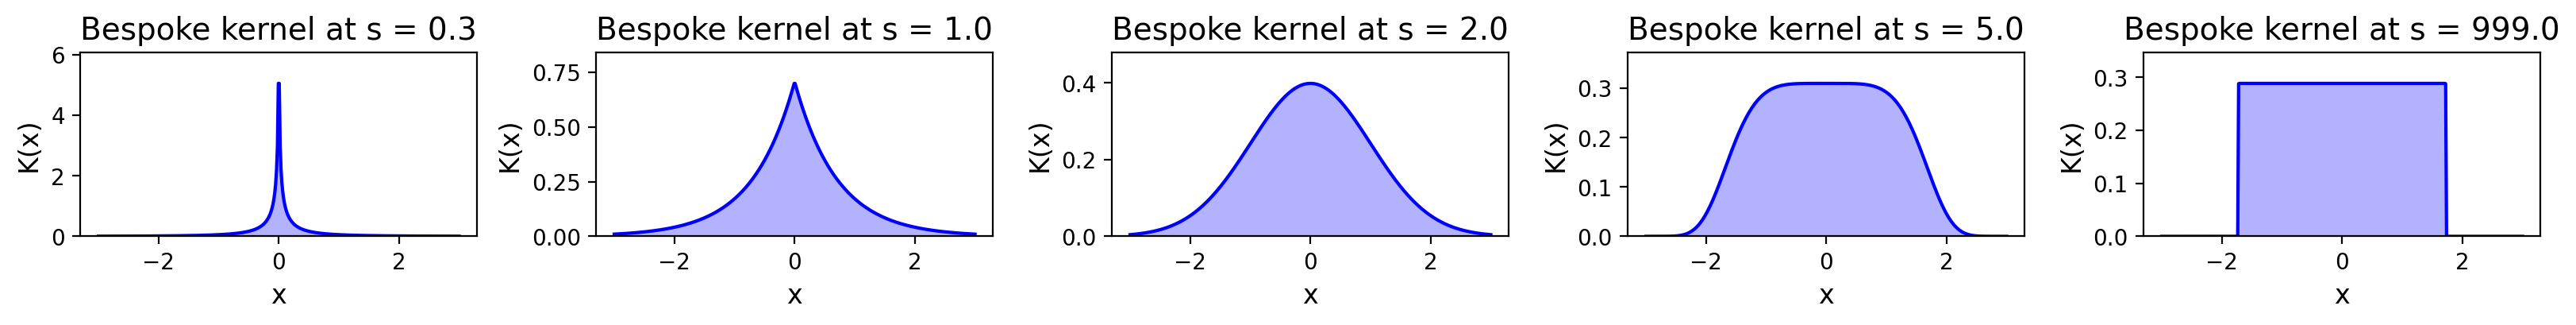

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def poly_exp_dist(n):
    """
    Constant variance
    """
    normalization = 2 * np.math.gamma(1+1/n)
    var = np.math.gamma(3/n + 1) / np.math.gamma(1+1/n) / 3
    std = np.sqrt(var)
    def curry_func(x):
        return np.exp(-np.power(np.abs(x * std), n)) * std / normalization 
    return curry_func

def plot_kernel(ax, s):
    kernel = poly_exp_dist(s)
    x_values = np.linspace(-3, 3, 400)
    k_values = kernel(x_values)
    
    ax.plot(x_values, k_values, 'b-')
    ax.fill_between(x_values, k_values, alpha=0.3, color='blue')
    
    ax.set_title(f'Bespoke kernel at s = {s:.1f}', fontsize=14)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('K(x)', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylim(0, max(k_values) * 1.2)

# Create a figure with three subplots arranged horizontally

s_list = [0.3,1,2,5,999]
fig, axs = plt.subplots(1, len(s_list), figsize=(4*len(s_list), 1.5), dpi=200)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
# Plot kernels for s = 1, 2, and 999
for ax,s in zip(axs,s_list):
    plot_kernel(ax, s)
save_path = "../paper_figures/bespoke_kernel_interpolation.png"
plt.savefig(save_path, bbox_inches='tight')

plt.show()

In [11]:
### Set LLaMA as the target
LLaMA_PDF_list = PDF_list_multi_traj[target_idx][PDF_slice]


In [12]:
from scipy.optimize import minimize

# Initial guess for parameters (bw, n)
initial_guess = [0.05, 2]

# Bounds for parameters: bw in [1e-3, 1e2], n in [0.1, 1.0]
# bounds = [(1e-3, 1e2), (0.1, 5.0)]
bounds = [(1e-3, 1e2), (0.05, 10.0)]
# bounds = [(1e-4, 1e2), (0.2, 0.2)]
# bounds = [(1e-3, 1e2), (0.4, 0.4)]
# bounds = [(1e-3, 1e2), (1, 1)]
# bounds = [(1e-3, 1e2), (2, 2)]


def objective_function(params, data, LLaMA_PDF):
    bw, n = params
    kernel = poly_exp_dist(n)
    KDE_PDF = KDE(data, kernel=kernel, bw=bw)
    return LLaMA_PDF.Hel_dist(KDE_PDF)
    # return LLaMA_PDF.L2_dist(KDE_PDF)

optimal_params = []
parameter_variances = []
minimized_hel_distances = []
optimal_KDE_PDFs = []

# Iterate over all steps
for step in range(len(LLaMA_PDF_list)):
    LLaMA_PDF = LLaMA_PDF_list[step]
    data = rescaled_full_series[:step+1]  # +1 to include the current step

    # Optimize
    result = minimize(
        objective_function,
        initial_guess,
        args=(data, LLaMA_PDF),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 10000}
    )
    
    # initial_guess = result.x  # Use last result as new initial guess
    optimal_bw, optimal_n = result.x
    minimized_objective = result.fun
    optimal_params.append((optimal_bw, optimal_n))
    minimized_hel_distances.append(minimized_objective)
    
    # Extract diagonal elements of the Hessian inverse
    hessian_inv = result.hess_inv.todense() 
    hessian_inv_diag = np.diag(hessian_inv)
    parameter_variances.append(hessian_inv_diag)

    # Generate and save the optimal KDE_PDF
    optimal_kernel = poly_exp_dist(optimal_n)
    optimal_KDE_PDF = KDE(data, kernel=optimal_kernel, bw=optimal_bw)
    optimal_KDE_PDFs.append(optimal_KDE_PDF)

    # print(f"Step {step}: Optimal bandwidth = {optimal_bw:.4f}, Optimal n = {optimal_n:.4f}")





In [13]:
# Unpack optimal parameters
optimal_bandwidths, optimal_ns = zip(*optimal_params)

# Unpack parameter variances
bandwidth_variances, n_variances = zip(*parameter_variances)

# Convert to numpy arrays for easier manipulation
bandwidth_variances = np.array(bandwidth_variances)
n_variances = np.array(n_variances)

# Calculate standard errors
bandwidth_std_errors = np.sqrt(bandwidth_variances) / 30
n_std_errors = np.sqrt(n_variances) / 30

In [61]:
real_silverman = False
# real_silverman = True

/tmp/ipykernel_246388/1723606524.py:54: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0,100)


../paper_figures/fitted_kernel_13b_gaussian_0.1_hel_dist_False.png


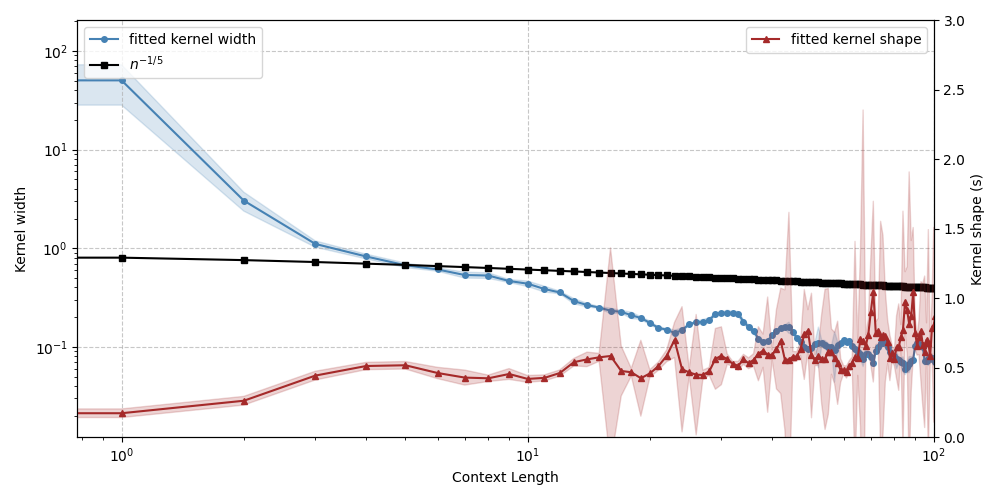

In [62]:
plot_hel_dist = True
plot_hel_dist = False

# Calculate Silverman's rule bandwidths
def silverman_bandwidth(data):
    n = len(data)
    std = np.std(data, ddof=1)  # Use sample standard deviation
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    if real_silverman:
        return 1.06 * min(std, iqr/1.34) * n**(-1/5)
    else:
        return n**(-1/5)

silverman_bandwidths = [silverman_bandwidth(rescaled_full_series[:i+1]) for i in range(1, len(optimal_bandwidths)+1)]


if plot_hel_dist:
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
else:
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot bandwidths
ax1.plot(optimal_bandwidths, marker='o', linestyle='-', markersize=4, label='fitted kernel width', c='steelblue')
ax1.fill_between(range(len(optimal_bandwidths)), 
                 np.array(optimal_bandwidths) - bandwidth_std_errors, 
                 np.array(optimal_bandwidths) + bandwidth_std_errors, 
                 alpha=0.2, color='steelblue')

if real_silverman:
    ax1.plot(silverman_bandwidths, marker='s', linestyle='-', markersize=4, label='Silverman', c='black')
else:
    ax1.plot(silverman_bandwidths, marker='s', linestyle='-', markersize=4, label=r'$n^{-1/5}$', c='black')

ax1.set_ylabel('Kernel width')
ax1.set_xlabel('Context Length')
ax1.set_xscale('log') 
ax1.set_yscale('log') 
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis for optimal n
ax2 = ax1.twinx()
ax2.plot(optimal_ns, marker='^', linestyle='-', markersize=4, color='brown', label='fitted kernel shape')
ax2.fill_between(range(len(optimal_ns)), 
                 np.array(optimal_ns) - n_std_errors, 
                 np.array(optimal_ns) + n_std_errors, 
                 alpha=0.2, color='brown')

ax2.set_ylabel('Kernel shape (s)')
ax2.legend(loc='upper right')
# ax2.set_ylim(0, 13)
ax2.set_ylim(0, 3)

ax1.set_xlim(0,100)

# plt.title('fitted bandwidth and kernel shape schedule')
# Save the figure
if real_silverman:
    save_path = f"{name}_hel_dist_{plot_hel_dist}_real_silverman.png"
else:
    save_path = f"{name}_hel_dist_{plot_hel_dist}.png"
print(save_path)
plt.savefig(save_path, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [32]:
if "fitted_KDE" in traj_names:
    PDF_list_multi_traj.pop()
    traj_names.pop()
traj_names.append("fitted_KDE")
PDF_list_multi_traj.append(optimal_KDE_PDFs)
    

In [33]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Checkbox
import numpy as np
length = PDF_slice.stop - PDF_slice.start
@interact(step=IntSlider(min=0, max=length-1, step=1, value=10),
          use_log_scale=Checkbox(value=False, description='Use Log Scale'))
def plot_PDFs_and_kernel(step, use_log_scale):
    plt.clf()  # Clear the entire figure
    fig, axes = plt.subplots(len(PDF_list_multi_traj) + 1, 1, figsize=(10, 8))
    if len(PDF_list_multi_traj) == 1:
        axes = [axes]
    else:
        axes = axes.flatten()  # Ensure axes is always a 1D array
    
    for i, (name, PDF_traj) in enumerate(zip(traj_names, PDF_list_multi_traj)):
        axes[i].clear()  # Clear the individual subplot
        PDF_traj[step].plot(ax=axes[i], statistic=False)
        axes[i].set_title(name)
        if use_log_scale:
            axes[i].set_yscale('log')
            axes[i].set_ylim(1e-3, 1e2)
        else:
            axes[i].set_yscale('linear')
    
    # Plot the optimal kernel
    axes[-1].clear()
    optimal_bw, optimal_n = optimal_params[step]
    kernel = poly_exp_dist(optimal_n)
    x = np.linspace(-5, 5, 1000)
    y = kernel(x / optimal_bw) / optimal_bw  # Scale the kernel by bandwidth
    axes[-1].plot(x, y)
    axes[-1].set_title(f'Optimal Kernel (bw={optimal_bw:.4f}, n={optimal_n:.4f})')
    axes[-1].set_xlabel('x')
    axes[-1].set_ylim(0.001,10)
    axes[-1].set_ylabel('Density')
    if use_log_scale:
        axes[-1].set_yscale('log')
        
    else:
        axes[-1].set_yscale('linear')

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=10, description='step', max=149), Checkbox(value=False, description='Use…

In [34]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Checkbox
import numpy as np

def plot_PDFs_and_kernel(steps_list=None, use_log_scale=True):
    length = PDF_slice.stop - PDF_slice.start

    def plot_step(step):
        plt.clf()  # Clear the entire figure
        fig = plt.figure(figsize=(15, 1.5))
        
        # Create a gridspec with 1 row and 4 columns
        gs = fig.add_gridspec(1, 4, width_ratios=[2, 2, 2, 1.5], wspace=0.1)
        
        axes = [fig.add_subplot(gs[0, i]) for i in range(4)]
        
        for i, (traj_name, PDF_traj) in enumerate(zip(traj_names[:3], PDF_list_multi_traj[:3])):
            PDF_traj[step].plot(ax=axes[i], statistic=False)
            axes[i].set_title(traj_name)
            if use_log_scale:
                axes[i].set_yscale('log')
                axes[i].set_ylim(1e-3, 1e2)
            else:
                axes[i].set_yscale('linear')
            
            # Remove y-axis labels for all but the first plot
            if i > 0:
                axes[i].set_ylabel('')
                axes[i].set_yticklabels([])
                # Remove y-axis ticks for all but the first plot
                axes[i].tick_params(axis='y', which='both', left=False, labelleft=False)
                
            # Adjust position to remove space between first three subplots
            if i > 0 and i < 3:
                pos = axes[i].get_position()
                axes[i].set_position([pos.x0 - 0.02 * i, pos.y0, pos.width, pos.height])
        
        # Plot the optimal kernel
        optimal_bw, optimal_n = optimal_params[step]
        silverman_bw = silverman_bandwidths[step]
        kernel = poly_exp_dist(optimal_n)
        gaussian_kernel = poly_exp_dist(2)
        x = np.linspace(-5, 5, 1000)
        y = kernel(x / optimal_bw) / optimal_bw  # Scale the kernel by bandwidth
        gaussian_y = gaussian_kernel(x / silverman_bw) / silverman_bw
        # axes[-1].set_title(f'kernels')
        axes[-1].plot(x, y, label='fitted kernel')
        axes[-1].plot(x, gaussian_y, color='red', label='gaussian kernel')
        axes[-1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
        axes[-1].set_xlabel('x')
        if use_log_scale:
            axes[-1].set_ylim(0.001, 10)
        
        axes[0].set_ylabel('Density')
        
        if use_log_scale:
            axes[-1].set_yscale('log')
        else:
            axes[-1].set_yscale('linear')

        # Set the step number as the title of the entire figure
        fig.suptitle(f'context length {step}', fontsize=16, y=1.25)

        if steps_list is not None:
            # Save the figure
            save_path = f"{name}_fitted_kernel_visualization_{step}_Log_{use_log_scale}.png"
            plt.savefig(save_path, bbox_inches='tight')
            plt.close(fig)
        else:
            plt.show()

    if steps_list is None:
        # Interactive mode
        interact(plot_step, 
                 step=IntSlider(min=0, max=length-1, step=1, value=10),
                 use_log_scale=Checkbox(value=True, description='Use Log Scale'))
    else:
        # Non-interactive mode: iterate over steps_list and save images
        for step in steps_list:
            plot_step(step)



### Figure 1 elements

In [35]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Checkbox
import numpy as np

def plot_PDFs_and_kernel(steps_list=None, use_log_scale=True):
    length = PDF_slice.stop - PDF_slice.start

    def plot_step(step):
        plt.clf()  # Clear the entire figure
        fig = plt.figure(figsize=(15, 1.5))
        
        # Create a gridspec with 1 row and 4 columns
        gs = fig.add_gridspec(1, 3, width_ratios=[2, 2, 2], wspace=0.1)
        
        axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
        
        for i, (traj_name, PDF_traj) in enumerate(zip(traj_names[:3], PDF_list_multi_traj[:3])):
            PDF_traj[step].plot(ax=axes[i], statistic=False, uniform_color = color_list[i])
            axes[i].set_title(traj_name)
            if use_log_scale:
                axes[i].set_yscale('log')
                axes[i].set_ylim(0.2e-3, 1e2)
            else:
                axes[i].set_yscale('linear')
            
            # Remove y-axis labels for all but the first plot
            if i > 0:
                axes[i].set_ylabel('')
                axes[i].set_yticklabels([])
                # Remove y-axis ticks for all but the first plot
                axes[i].tick_params(axis='y', which='both', left=False, labelleft=False)
                
            # Adjust position to remove space between first three subplots
            if i > 0 and i < 3:
                pos = axes[i].get_position()
                axes[i].set_position([pos.x0 - 0.025 * i, pos.y0, pos.width, pos.height])
        
        # Plot the optimal kernel
        optimal_bw, optimal_n = optimal_params[step]
        silverman_bw = silverman_bandwidths[step]
        kernel = poly_exp_dist(optimal_n)
        gaussian_kernel = poly_exp_dist(2)
        x = np.linspace(-5, 5, 1000)
        y = kernel(x / optimal_bw) / optimal_bw  # Scale the kernel by bandwidth
        gaussian_y = gaussian_kernel(x / silverman_bw) / silverman_bw
        
        axes[0].set_ylabel('Density')
        

        # Set the step number as the title of the entire figure
        fig.suptitle(f'context length {step}', fontsize=16, y=1.25)

        if steps_list is not None:
            # Save the figure
            save_path = f"{name}_fitted_kernel_visualization_{step}_Log_{use_log_scale}.png"
            plt.savefig(save_path, bbox_inches='tight')
            plt.close(fig)
        else:
            plt.show()

    if steps_list is None:
        # Interactive mode
        interact(plot_step, 
                 step=IntSlider(min=0, max=length-1, step=1, value=10),
                 use_log_scale=Checkbox(value=True, description='Use Log Scale'))
    else:
        # Non-interactive mode: iterate over steps_list and save images
        for step in steps_list:
            plot_step(step)



In [36]:
# Usage:
# For interactive mode:
plot_PDFs_and_kernel()

interactive(children=(IntSlider(value=10, description='step', max=149), Output()), _dom_classes=('widget-inter…

In [37]:

# For non-interactive mode:
# plot_PDFs_and_kernel(steps_list=[100], use_log_scale=True)
plot_PDFs_and_kernel(steps_list=[0,1,2,3,4,5,10,20,30,40,50,60,70,80,90,100,130,140], use_log_scale=True)
plot_PDFs_and_kernel(steps_list=[0,1,2,3,4,5,10,20,30,40,50,60,70,80,90,100,130,140], use_log_scale=False)


<Figure size 640x480 with 0 Axes>

In [38]:
### Calculate geodesic 
PDF_geodesic_list_multi_traj = []
example_PDF_list = PDF_list_multi_traj[0]
for true_stat in true_statistics:
    PDF_geodesic_list_multi_traj += [geodesic_from_true_stat(example_PDF_list,
                                                             true_stat,
                                                             geodesic_steps=geodesic_steps)]

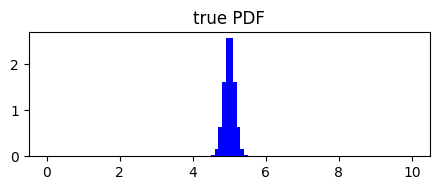

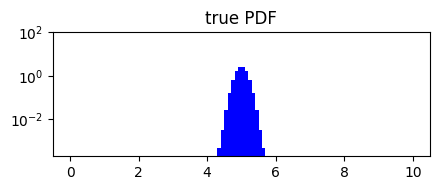

In [39]:

true_PDF = PDF_geodesic_list_multi_traj[-1][-1]

# Create a figure with two subplots
for use_log in [False,True]:
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 2))
    true_PDF.plot(ax=ax, statistic=False,uniform_color='blue')
    if use_log:
        ax.set_yscale('log')
        ax.set_ylim(0.2e-3, 1e2)
    

    save_path = f"{name}_true_PDF_Log_{use_log}.png"
    ax.set_title("true PDF") 
    plt.savefig(save_path, bbox_inches='tight')
    plt.tight_layout()


### Visualization


In [40]:
### Calculate gaussian sub-manifold:
if gaussian_manifold:
    # same length as geodesic, for easy plotting
    sigma_list = np.linspace(0,5,geodesic_steps)
    mean_list = np.array([5]*geodesic_steps)
    PDF_list = PDF_list_multi_traj[0]
    sub_manifold_list = gaussian_manifold_generator(PDF_list, sigma_list, mean_list)
    PDF_geodesic_list_multi_traj += [sub_manifold_list]
    
    

/tmp/ipykernel_246388/3062036002.py:50: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))
/tmp/ipykernel_246388/3062036002.py:50: RuntimeWarning: invalid value encountered in divide
  return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))


In [41]:
### Calculate temperature sub-manifold:
if temperature_manifold:
    temperature_list = np.logspace(np.log10(1), np.log10(20), geodesic_steps)
    sub_manifold_list = temperature_manifold_generator(true_PDF, temperature_list)
    PDF_geodesic_list_multi_traj += [sub_manifold_list]
    
    %matplotlib inline 
    from ipywidgets import interact
    def plotter(idx):
        fig=plt.figure(figsize = (5,1))
        ax = fig.add_subplot(111)
        sub_manifold_list[idx].plot(ax=ax, statistic = False)

    interact(plotter, idx=(0, geodesic_steps-1, 1))

In [42]:

traj_len = PDF_slice.stop - PDF_slice.start
PDF_emb_list = []
for PDF_list in PDF_list_multi_traj:
    PDF_emb_list += PDF_list[PDF_slice]

for i, geodesic_list in enumerate(PDF_geodesic_list_multi_traj):
    if i == 0:
        PDF_emb_list += geodesic_list
    else:
        PDF_emb_list += geodesic_list[1:]
        

### Compute pair-wise distance

In [43]:
# Initialize the matrix D with zeros. The size of the matrix is determined by the length of PDF_list.
num_PDFs = len(PDF_emb_list)
D_Hel = np.zeros((num_PDFs, num_PDFs))


In [44]:
### un-parallelized

# # Populate the upper triangle of the matrix with the BT distances.
# for i in range(num_PDFs):
#     for j in range(i+1, num_PDFs):  # Start from i+1 to avoid computing the distance of an object with itself
#         D_Hel[i, j] = PDF_emb_list[j].Hel_dist(PDF_emb_list[i])

In [45]:
### parallelized

import numpy as np
from multiprocessing import Pool, cpu_count

def compute_distance(args):
    i, j, PDF_i, PDF_j = args
    return (i, j, PDF_j.Hel_dist(PDF_i))

def parallel_distance_matrix(PDF_emb_list):
    num_PDFs = len(PDF_emb_list)
    D_Hel = np.zeros((num_PDFs, num_PDFs))
    
    # Prepare arguments for parallel processing
    args = [(i, j, PDF_emb_list[i], PDF_emb_list[j]) 
            for i in range(num_PDFs) 
            for j in range(i+1, num_PDFs)]
    
    # Use all available CPU cores
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(compute_distance, args)
    
    # Fill the matrix with the results
    for i, j, distance in results:
        D_Hel[i, j] = distance
    
    return D_Hel

# Use the function
D_Hel = parallel_distance_matrix(PDF_emb_list)

In [46]:
# Copy the upper triangle to the lower triangle to make the matrix symmetric.
# truncate
D_BT = -np.log(1-np.square(D_Hel)/2)
D_Hel = D_Hel + D_Hel.T
D_BT = D_BT + D_BT.T

P = np.eye(num_PDFs) - np.ones(num_PDFs)/num_PDFs
XXT_Hel = -P @ np.square(D_Hel) @ P
XXT_BT = -P @ D_BT @ P

### Hellinger Embedding

array([109.1963804 ,  49.47073775,   3.02614775])

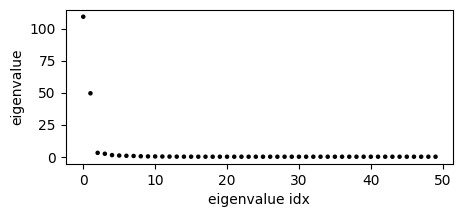

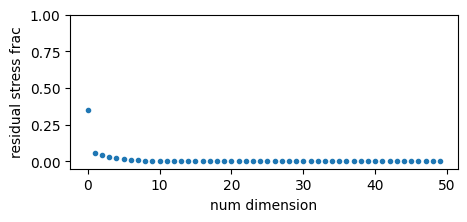

In [47]:
sigma, U = np.linalg.eigh(XXT_Hel)
# Reorder sigma and U based on the absolute value of sigma in decreasing order
idx = np.argsort(np.abs(sigma))[::-1]
sigma = sigma[idx]
U = U[:, idx]
U_rescaled = U * np.sqrt(np.abs(sigma))
U_rescaled_original = U_rescaled.copy() 
# U_rescaled = U * sigma

# %matplotlib inline 
# Plot with color based on the sign of sigma
spectrum_cutoff = 50
colors = ['black' if value > 0 else 'red' for value in sigma[:spectrum_cutoff]]
plt.figure(figsize=(5,2), dpi=100)
plt.scatter(range(spectrum_cutoff), np.abs(sigma[:spectrum_cutoff]), c=colors, s = 5)
plt.xlabel('eigenvalue idx')
plt.ylabel('eigenvalue')
# plt.yscale("log")

total_var = np.sum(np.abs(sigma))
explained_var = np.cumsum(np.abs(sigma))
plt.figure(figsize=(5,2), dpi=100)
plt.plot(1-explained_var[:50]/total_var, marker = '.', lw =0)
# plt.ylim(0,1.1)
# plt.yscale('log')
plt.xlabel('num dimension')
plt.ylabel('residual stress frac')
plt.ylim(-0.05,1)
sigma[:3]

### 3D Embedding

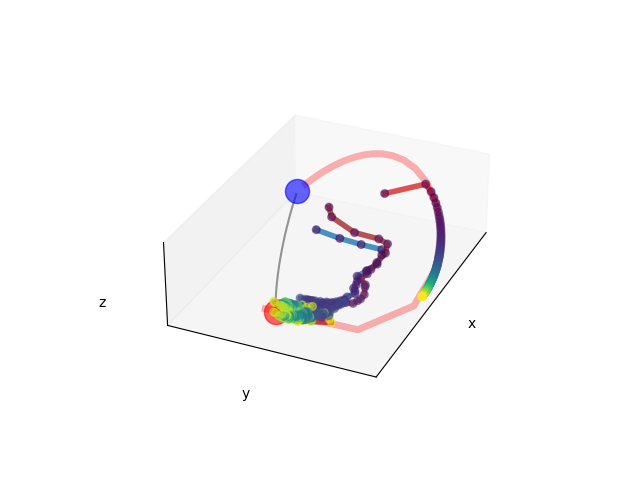

In [48]:
interactive = 1

time_cutoff = -geodesic_steps
interval = 1
geodesic = True
shadows = False
shadow_alpha = 0.05

num_geodesics = len(PDF_geodesic_list_multi_traj)
num_trajs = len(PDF_list_multi_traj)
submanifold = gaussian_manifold or temperature_manifold

filenames = []

def plotter_with_initial_angle(angle, save_path = None):

    if interactive:
        #interactive 3D plot
        %matplotlib widget 
        fig = plt.figure(dpi = 100)
    else:    
    # static 3D plot
        %matplotlib inline 
        fig = plt.figure(dpi = 100, figsize=(8,8))
        
    ax = fig.add_subplot(111, projection='3d')

    for i in range(num_trajs):
        # learning trajectories
        ax.scatter3D(U_rescaled[i*traj_len:(i+1)*traj_len:interval,0], U_rescaled[i*traj_len:(i+1)*traj_len:interval,1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,2], c=range(int(traj_len/interval)), s = 30, alpha = 0.5)
        ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,0], U_rescaled[i*traj_len:(i+1)*traj_len:interval,1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,2], alpha = 0.8, lw = 4, c = color_list[i])

    # ignorance is the shared
    ign_index = num_trajs * traj_len
    ax.scatter3D(U_rescaled[ign_index,0], U_rescaled[ign_index,1], U_rescaled[ign_index,2], c='blue', s = 300, alpha = 0.6)

    for i in range(num_geodesics-submanifold):
        # geodesics
        start = ign_index+i*(geodesic_steps-1)+1
        end = ign_index+(i+1)*(geodesic_steps-1)+1
        # print(end, start)
        ax.scatter3D(U_rescaled[end-1,0], U_rescaled[end-1,1], U_rescaled[end-1,2], c='red', s = 300, alpha = 0.6)
        if geodesic:
            ax.plot(U_rescaled[start : end,0], 
                    U_rescaled[start : end,1],
                    U_rescaled[start : end,2], c='black', alpha = 0.4)

    if gaussian_manifold:
        # gaussian manifold
        start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
        end = ign_index+num_geodesics*(geodesic_steps-1)+1
        ax.plot(U_rescaled[start : end,0], U_rescaled[start : end,1], U_rescaled[start : end,2], c='red', alpha = 0.3, lw = 5, label = "gaussian manifold")

    if temperature_manifold:
        # gaussian manifold
        start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
        end = ign_index+num_geodesics*(geodesic_steps-1)+1
        ax.plot(U_rescaled[start : end,0], U_rescaled[start : end,1], U_rescaled[start : end,2], c='red', alpha = 0.3, lw = 5, label = "temperature manifold")


    # if not interactive:
    #     ax.legend()
            
            
    x_min, x_max = U_rescaled[:,0].min(), U_rescaled[:,0].max()
    y_min, y_max = U_rescaled[:,1].min(), U_rescaled[:,1].max()
    z_min, z_max = U_rescaled[:,2].min(), U_rescaled[:,2].max()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    if shadows:
        for zdir, zs, idx_tuple in zip(['x','y','z'],[x_min, y_max, z_min],[(1,2),(0,2),(0,1)]):        
            for i in range(len(PDF_list_multi_traj)):
                ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[0]], U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[1]], c=range(int(traj_len/interval)), alpha = shadow_alpha, zs=zs, zdir=zdir)

        
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(elev=30, azim=angle)
    # plt.title(f"fraction of explained variance {explained_var[2]/total_var*100:.0f}%")
    # plt.axis('equal')
    ax.set_aspect('equal')
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        filenames.append(save_path)
        plt.close(fig)  # Save the plot without displaying it
    
    
plotter_with_initial_angle(angle = 24)    

### Animate

In [49]:
# filenames = []
# num_frames = 300
# for frame_idx in range(num_frames):

#     angle = 2 * 360 * (frame_idx/num_frames)
#     save_path = f"../figures/animation/{frame_idx}.png"
#     plotter_with_initial_angle(angle = angle, save_path = save_path)    

In [50]:
# # Create a GIF using snapshot made
# import imageio.v2 as imageio
# remark = name.split("/")[-1]
# with imageio.get_writer(f'../figures/{remark}.gif', mode='I', duration=30000 / num_frames, loop=0) as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

### 2D Embedding


In [55]:
invert_x = 0
invert_y = 1

fraction of explained variance 94%


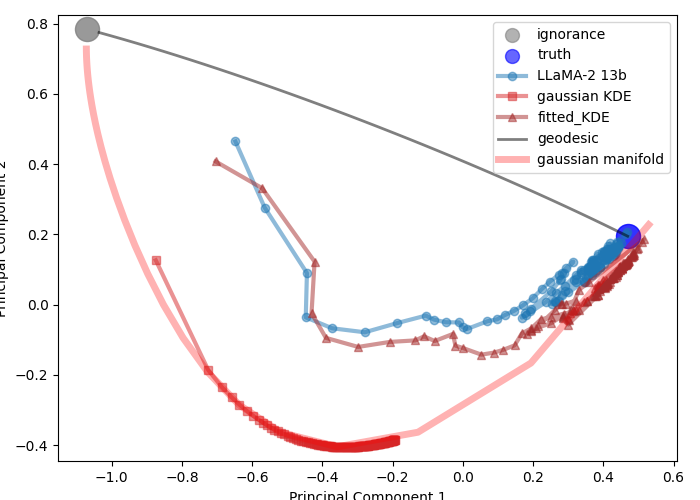

In [59]:
dim1 = 0
dim2 = 1
U_rescaled = U_rescaled_original.copy() 
if invert_x:
    U_rescaled[:,dim1] = -U_rescaled[:,dim1]
if invert_y:
    U_rescaled[:,dim2] = -U_rescaled[:,dim2]


fig = plt.figure(dpi = 100, figsize=(7,5))
ax = fig.add_subplot(111)
ax.scatter([],[], c='gray', s = 100, alpha = 0.6, label = 'ignorance')
ax.scatter([],[], c='blue', s = 100, alpha = 0.6, label = 'truth')
for i in range(len(PDF_list_multi_traj)):    
    # ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], c=range(int(traj_len/interval)), alpha = 0.5)
    # ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], c = color_list[i], alpha = 0.5)
    ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], alpha = 0.5, lw=3, 
            label = traj_names[i], 
            c = color_list[i],
            marker = marker_list[i])

# ignorance is shared
ign_index = num_trajs * traj_len
ax.scatter(U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2], c='grey', s = 300, alpha = 0.8)
# ax.annotate('ignorance', (U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2]),textcoords="offset points", xytext=(10,10), ha='center')

for i in range(num_geodesics-submanifold):
    # geodesics
    start = ign_index+i*(geodesic_steps-1)+1
    end = ign_index+(i+1)*(geodesic_steps-1)+1
    ax.scatter(U_rescaled[end-1,dim1], U_rescaled[end-1,dim2], c='blue', s = 300, alpha = 0.8)
    if geodesic:
        ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='black', alpha=0.5, lw=2)


if geodesic:
    ax.plot([], c='black', alpha=0.5, lw=2, label = 'geodesic')  # Increased line width to thicken the line
# ax.scatter([],[], c='purple', alpha = 0.5, label = "LLM prediction")
  
if submanifold:
    label = "temperature manifold" if temperature_manifold else "gaussian manifold"
    start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
    end = ign_index+num_geodesics*(geodesic_steps-1)+1
    ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='red', alpha = 0.3, lw = 5, label = label)

# plt.xticks([])  # Turn off x-axis ticks
# plt.yticks([])  # Turn off y-axis ticks

# Invert the y-axis
# ax.invert_yaxis()


# remove repeated labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), loc='best')


# Move the legend outside the plot
plt.legend(by_label.values(), by_label.keys(), loc='upper right')
# Move the legend outside the plot to the right
# plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1.02, 0.5))

# Adjust the layout to prevent the legend from being cut off
plt.tight_layout()
# Label x and y axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

print(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
plt.axis('equal')
save_path = f"{name}_Hellinger_2D_{explained_var[1]/total_var*100:.0f}.png"
plt.savefig(save_path, bbox_inches='tight')  # Ensure the legend is included in the saved figure



In [57]:
save_path

'../paper_figures/fitted_kernel_13b_gaussian_0.1_Hellinger_2D_94.png'

### 1D Embedding: Hellinger distance to truth


IndexError: list index out of range

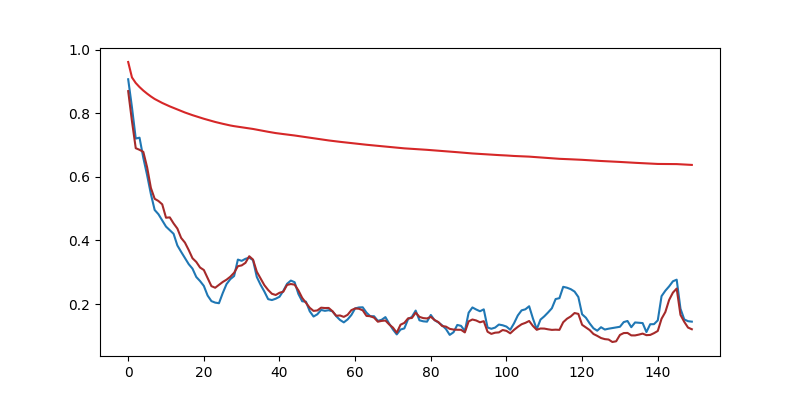

In [54]:
loss_curve_list = []
num_traj_list = [0,1,2,3,4,5,6,7]
num_traj_list = [0,1,2,3,4,5]
# num_traj_list = [0,1,2,3]
for num_traj in num_traj_list:
    loss_curve = D_Hel[num_traj * traj_len : (num_traj+1) * traj_len, num_trajs * traj_len + geodesic_steps-1]
    loss_curve_list += [loss_curve]

fig = plt.figure(dpi = 100, figsize=(8,4))
ax = fig.add_subplot(111)
for i, loss_curve in enumerate(loss_curve_list):
    ax.plot(loss_curve, label = traj_names[i], c = color_list[i])
plt.legend()    

plt.ylabel("Hellinger loss")
plt.xlabel("Context length")
save_path = f"{name}_Hellinger_1D.png"
plt.savefig(save_path)
# plt.xscale('log')
# plt.yscale('log')

plt.show()



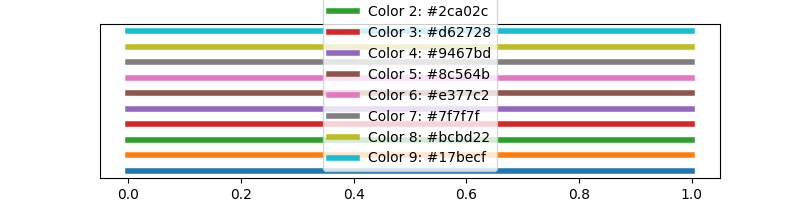

Color 0: #1f77b4
Color 1: #ff7f0e
Color 2: #2ca02c
Color 3: #d62728
Color 4: #9467bd
Color 5: #8c564b
Color 6: #e377c2
Color 7: #7f7f7f
Color 8: #bcbd22
Color 9: #17becf


In [ ]:
import matplotlib.pyplot as plt

# Get the default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot lines with each color in the default color cycle
plt.figure(figsize=(8, 2))
for i, color in enumerate(default_colors):
    plt.plot([0, 1], [i, i], label=f'Color {i}: {color}', color=color, linewidth=4)

plt.legend()
plt.yticks([])
plt.show()

# Print the color codes
for i, color in enumerate(default_colors):
    print(f'Color {i}: {color}')

### Bhattacharyya Embedding

In [ ]:
# sigma, U = np.linalg.eigh(XXT_BT)
# # Reorder sigma and U based on the absolute value of sigma in decreasing order
# idx = np.argsort(np.abs(sigma))[::-1]
# sigma = sigma[idx]
# U = U[:, idx]

# # U_rescaled = U * sigma
# # Plot with color based on the sign of sigma
# cutoff = 200
# colors = ['black' if value > 0 else 'red' for value in sigma[:cutoff]]
# plt.figure(figsize=(5,2), dpi=150)
# plt.scatter(range(cutoff), np.abs(sigma[:cutoff]), c=colors, s = 5)
# plt.xlabel('eigenvalue idx')
# plt.ylabel('eigenvalue')
# plt.yscale("log")

# total_var = np.sum(np.abs(sigma))
# explained_var = np.cumsum(np.abs(sigma))
# plt.figure(figsize=(5,2), dpi=150)
# plt.plot(1-explained_var[:50]/total_var, marker = '.', lw =0)
# # plt.ylim(0,1.1)
# # plt.yscale('log')
# plt.xlabel('num dimension')
# plt.ylabel('unexplained stress fraction')

In [ ]:
# time_cutoff = 300
# interval = 10
# %matplotlib inline 
# save_path = f"../figures/{file.stem}_BT_2D.png"
# fig = plt.figure(dpi = 100, figsize=(8,4))

# dim1 = 0
# dim2 = 1

# plt.scatter(U_rescaled[:time_cutoff:interval,dim1], U_rescaled[:time_cutoff:interval,dim2], c=range(int(time_cutoff/interval)), alpha = 0.6)
# plt.plot(U_rescaled[:time_cutoff:interval,dim1], U_rescaled[:time_cutoff:interval,dim2], alpha = 0.2, label ="learning traj")

# plt.plot(U_rescaled[-geodesic_steps:,dim1], U_rescaled[-geodesic_steps:,dim2], alpha = 0.5, c='black', label ="geodesic")
# plt.scatter(U_rescaled[-1,dim1], U_rescaled[-1,dim2], c='red', s = 100, label ="truth", alpha = 0.6)
# plt.scatter(U_rescaled[-geodesic_steps,dim1], U_rescaled[-geodesic_steps,dim2], c='blue', s = 100, label ="ignorance", alpha = 0.6)

# plt.xticks([])  # Turn off x-axis ticks
# plt.yticks([])  # Turn off y-axis ticks
# plt.title(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
# plt.legend()
# plt.axis('equal');
# plt.savefig(save_path)



In [ ]:
# time_cutoff = 120
# interval = 2

# interactive = 1
# shadows = 1
# shadow_alpha = 0.05
# if interactive:
#     #interactive 3D plot
#     %matplotlib widget 
#     fig = plt.figure(dpi = 100)
# else:    
# # static 3D plot
#     %matplotlib inline 
#     fig = plt.figure(dpi = 100, figsize=(8,8))
    
# save_path = f"../figures/{file.stem}_BT_3D.png"
# ax = fig.add_subplot(111, projection='3d')

# # invert x axis
# # U_rescaled[:,0] = -U_rescaled[:,0]
# ax.scatter3D(U_rescaled[:time_cutoff:interval,0], U_rescaled[:time_cutoff:interval,1], U_rescaled[:time_cutoff:interval,2], c=range(int(time_cutoff/interval)), s = 30, alpha = 0.8)
# ax.scatter3D(U_rescaled[-geodesic_steps,0], U_rescaled[-geodesic_steps,1], U_rescaled[-geodesic_steps,2], c='blue', s = 100, label ="ignorance", alpha = 0.6)
# ax.scatter3D(U_rescaled[-1,0], U_rescaled[-1,1], U_rescaled[-1,2], c='red', s = 100, label ="truth", alpha = 0.6)
# ax.plot(U_rescaled[:time_cutoff:interval,0], U_rescaled[:time_cutoff:interval,1],U_rescaled[:time_cutoff:interval,2], alpha = 0.4, label ="learning traj")
# ax.plot(U_rescaled[-geodesic_steps:,0], U_rescaled[-geodesic_steps:,1],U_rescaled[-geodesic_steps:,2], c='black', alpha = 0.4, label ="geodesic")
# ax.legend()


# x_min, x_max = U_rescaled[:,0].min(), U_rescaled[:,0].max()
# y_min, y_max = U_rescaled[:,1].min(), U_rescaled[:,1].max()
# z_min, z_max = U_rescaled[:,2].min(), U_rescaled[:,2].max()
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

# if shadows:
#     # 2D projections
#     for zdir, zs, idx_tuple in zip(['x','y','z'],[x_min, y_max, z_min],[(1,2),(0,2),(0,1)]):
#         ax.plot(U_rescaled[:time_cutoff:interval,idx_tuple[0]], U_rescaled[:time_cutoff:interval,idx_tuple[1]], zdir=zdir, c = 'gray', alpha = shadow_alpha, zs=zs)
#         ax.scatter(U_rescaled[:time_cutoff:interval,idx_tuple[0]], U_rescaled[:time_cutoff:interval,idx_tuple[1]], zdir=zdir, c = range(int(time_cutoff/interval)), alpha = shadow_alpha, zs=zs)
        
#         ax.plot(U_rescaled[-geodesic_steps,idx_tuple[0]], U_rescaled[-geodesic_steps,idx_tuple[1]], zdir=zdir, c = 'blue', alpha = shadow_alpha, zs=zs, marker = 'o', markersize=10)
#         ax.plot(U_rescaled[-1,idx_tuple[0]], U_rescaled[-1,idx_tuple[1]], zdir=zdir, c = 'red', alpha = shadow_alpha, zs=zs, marker = 'o', markersize=10)
#         ax.plot(U_rescaled[-geodesic_steps:,idx_tuple[0]], U_rescaled[-geodesic_steps:,idx_tuple[1]], zdir=zdir, c = 'black', alpha = shadow_alpha, zs=zs)
        
    
# ax.set_xticks([]) 
# ax.set_yticks([]) 
# ax.set_zticks([])

# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# plt.title(f"fraction of explained variance {explained_var[2]/total_var*100:.0f}%")
# # plt.axis('equal')
# ax.set_aspect('equal')
# if not interactive:
#     plt.savefig(save_path)
# plt.show()